In [25]:
import numpy as np
from typing import Optional, Tuple
from typing_extensions import Literal
from matplotlib import pyplot as plt

# generate data

In [26]:
# In real world, you cannot learn how the data was generated. So do not rely on this function when coding your lab.
def generate_data(dim, num):
    x = np.random.normal(0, 10, [num, dim])
    coef = np.random.uniform(-1, 1, [dim, 1])
    pred = np.dot(x, coef)
    pred_n = (pred - np.mean(pred)) / np.sqrt(np.var(pred))
    label = np.sign(pred_n)
    mislabel_value = np.random.uniform(0, 1, num)
    mislabel = 0
    for i in range(num):
        if np.abs(pred_n[i]) < 1 and mislabel_value[i] > 0.9 + 0.1 * np.abs(pred_n[i]):
            label[i] *= -1
            mislabel += 1
    return x, label, mislabel/num

In [27]:
# example
x, y, mr = generate_data(10, 100)

In [28]:
x[:5], y[:5]

(array([[ 17.00443792, -14.45346963,  -8.0044522 ,   9.2802788 ,
          17.03429102,  -1.10433039,   0.94978784,   3.42420652,
         -14.28204171,  -1.23714566],
        [-13.21287164, -12.24264838,  13.44864295, -10.78217014,
          15.65447513,  11.41810762,   5.92648579,   8.17231343,
          -1.28216079,  11.23338799],
        [  1.30745596,  -6.43070657,  -8.19751142,  14.03804134,
           0.92781443,   2.29349889,  -9.80822263,   2.64694865,
           7.82872216,   1.72808385],
        [-10.65082729,  20.49104902,   9.97422808, -16.26672609,
          -1.15308981,  14.19635203,  13.98079594,   1.98743083,
           0.46047084,   8.34734024],
        [  6.73520792,   6.25635909,   9.78395155, -14.89470456,
          -7.84274446,  -5.24634423,  -8.62255279,   0.86101595,
          -5.04973646,  -7.65563433]]),
 array([[-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.]]))

# write your model class

In [29]:
# you can do anything necessary about the model
# SGD 梯度下降法
from optparse import Option
from typing import Literal


class SVM1:
    def __init__(self, dim, learning_rate:float, max_iter:int, C:float):
        """
        You can add some other parameters, which I think is not necessary
        """
        self.lr = learning_rate     # 学习率
        self.max_iter = max_iter    # 最大迭代次数
        self.C = C  # 惩罚系数
        self.dim = dim  # 数据维度  


    def fit(self, X:np.ndarray, y:np.ndarray, val_data: Optional[Tuple[np.ndarray, np.ndarray]] = None):
        """
        Fit the coefficients via your methods
        用数据集(X,y)拟合模型, 并记录拟合过程中每个epoch的训练错误率及验证错误率(如果提供验证集val_data)
        """
        self.train_data = (X, y)
        #train_datas = np.c_[X, y]
        self.val_data = val_data
        X = self.__transfrom(X)
        #print(X.shape)     X.shape = (90000,30)
        #print(y.shape)     y.shape = (90000,1)
        #self.w = np.zeros(X.shape[1])
        self.w = np.zeros((1, self.dim),dtype=float)   # 初始化权重 w = 0 此时 w.shape = (1,30)
        self.w = self.w.T   # 将 w 转置 此时 w.shape = (30,1)
        
        self.b = 0
        self.err = {'train':[], 'val':[]}
        # SGD:
        for i in range(self.max_iter):
            e = 1 - (np.dot(X, self.w) + self.b) * y # hinge损失 1-(WX+b)*y = 1-yf(x)
            # print(e.shape) e.shape = (90000,1)
            ei = (e >= 0)
            #print(X[ei[:,0]])
            if not ei.any():    # 如果样本的 1-(WX+b)*y < 0, 那么参数保持不变
                break
            delta_w = self.w - self.C * np.dot(X[ei[:,0]].T, y[ei[:,0]])  # delta_w.shape = (30,1)
            delta_b = -self.C * np.sum(y[ei[:,0]])   
            if np.sum(delta_w ** 2) + delta_b ** 2 < 1:
                break
            self.w -= self.lr * delta_w # 更新 w
            self.b -= self.lr * delta_b # 更新 b
            if(i % 10 == 0):
                train_acc = self.score(X, y, metric='acc')
                print("已经%d个epoch  train acc = %f" %(i, train_acc))
                #self.C += 1
            self.update_err()

    def __transfrom(self, X: np.ndarray):
        return X


    def update_err(self):
        self.err['train'].append(self.score(self.train_data[0], self.train_data[1], 'err'))
        if self.val_data:
            self.err['val'].append(self.score(self.val_data[0], self.val_data[1], 'err'))

        
    def predict(self, X):
        """
        Use the trained model to generate prediction probabilities on a new
        collection of data points.
        用训练好的模型预测X的标签
        """
        X = self.__transfrom(X)
        pred = np.sign(np.dot(X, self.w) + self.b)
        pred[pred == 0] = 1     # >=0 的全为 1
        return pred

    def score(self, X:np.ndarray, target:np.ndarray, metric: Literal['err', 'acc', 'f1'] = 'acc'):
        """
        用模型预测X的标签并与真实标签target比较, 计算评估函数值。
        """
        assert(X.shape[0] == target.size)
        if metric == 'acc' or 'err':
            y_pred = self.predict(X)
            acc = np.sum(y_pred == target) / target.size
            return acc if metric == 'acc' else 1-acc
        if metric == 'f1':
            y_pred = self.predict(X)
            TP = np.sum(np.logical_and(y_pred == 1, target == 1))
            prec = TP / np.sum(y_pred == 1)
            recall = TP / np.sum(target == 1)
            return 2 * prec * recall / (prec + recall)

    
    def plot_boundary(self, X:np.ndarray, y:np.ndarray, sv:bool=True):
        """
        绘制决策边界，支持超平面，并标出支持向量
        """
        #assert X.shape[1] == 2
        x1, x2 = X[:, 0], X[:, 1]
        x1_lim = np.array([np.min(x1), np.max(x1)]) + np.array([-1, 1]) * .05 * np.ptp(x1)
        x2_lim = np.array([np.min(x2), np.max(x2)]) + np.array([-1, 1]) * .05 * np.ptp(x2)
        fig, ax = plt.subplots()
        ax.set_xlim(x1_lim[0], x1_lim[1])
        ax.set_ylim(x2_lim[0], x2_lim[1])
        acc = self.score(X, y, 'acc')
        ax.set_title("Boundary of SVM\naccuracy={}".format(round(acc, 3)))
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        x1_sample = np.linspace(np.floor(x1_lim[0]), np.ceil(x1_lim[1]), num = 100)

        def get_x2_sample(y):
            return (y - (self.b + self.w[0] * x1_sample)) / (self.w[1] + 1e-10)
        ax.plot(x1_sample, get_x2_sample(y=0), 'r-', linewidth=1.5, label='clf plane')
        ax.plot(x1_sample, get_x2_sample(y=1), 'r--', linewidth=1.5, label='support plane')
        ax.plot(x1_sample, get_x2_sample(y=-1), 'r--', linewidth=1.5)
        #print(x1[y==1])
        yi_1 = (y == 1)
        yi_0 = (y == -1)
        #print(yi_0)
        ax.scatter(x1[yi_1[:,0]], x2[yi_1[:,0]], c='#ff7f0e', label='positive')
        ax.scatter(x1[yi_0[:,0]], x2[yi_0[:,0]], c='#e377c2', label='negative')
        
        if sv:
            sv = (1 - (np.dot(X, self.w) + self.b) * y) >= 0
            ax.scatter(x1[sv[:,0]], x2[sv[:,0]], marker='o', s=150,
                       facecolors='none', edgecolors='#1f77b4',
                       linewidth=2, label='support vector')
        plt.legend(loc='upper left')
        plt.show()


    def plot_learning_curve(self):
        """
        绘制学习曲线
        """
        fig, ax = plt.subplots()
        ax.set_title('Learning curve with lr={}'.format(self.lr))
        ax.set_xlabel('epoch')
        ax.set_ylabel('error rate')
        ax.plot(np.arange(1, len(self.err['train']) + 1), self.err['train'], label='training error')
        if self.err['val']: 
            ax.plot(np.arange(1, len(self.err['val']) + 1), self.err['val'], label='testing error')
        ax.legend()
        plt.show()


        

In [30]:
# you can do anything necessary about the model
# 第二种方法：SMO（序列最小优化算法）我认为 SMO 也属于坐标轮换法的一种，只不过它每次选择两个坐标
# SVM 的对偶函数具有两个约束条件，而坐标轮换法适用于求无约束条件的
# 步骤：
#  1. 类比坐标轮换法，每次选取两个变量 a1,a2，根据约束条件得到 a1y1 + a2y2 = -sum(aiyi) i = 3,...,n
#  2. 由于 -sum(aiyi) i = 3,...,n 可以看成常量，可用松弛变量 E 代替，得到 a1 = (E - a2y2)y1
#  3. 原优化函数可写为 W(a1, a2,..., an) = W((E - a2y2)y1, a2, a3,..., an)
#  4. 因为 a3,...,an 为常数，则 W 为关于 a2 的二次函数，通过对其求导，可以得出 W 的最优解
#     由于 a2 存在约束，则存在有上下限的问题，需要对在 W 取得最优解时的 a2 加以判断，最终更新 a2 与 a1，b 的值
#  5. 类比坐标轮换法，在一轮结束后，判断条件 || ak^n - ak-1^n|| <= epsilon，a = (a1, a2,..., an), k 为轮数
#     若不满足即可开启下一轮，重复步骤 2。若满足，则停止迭代，输出最优解 a* = ak^n
# 这里我进行了简化，我选择ij不用启发式的选择，而是用最普通的随机

from random import random


class SVM2:
    def __init__(self, dim, maxiter, C):
        """
        You can add some other parameters, which I think is not necessary
        """
        self.maxiter = maxiter  # 最大迭代次数
        self.C = C  # 惩罚系数
        self.epsilon = 1e-4

    def linear_kernel(self, x1, x2):  # 表6.1（线性核）
        return np.dot(x1, x2.T)

    def getsign(self, X, w, b):
        return np.sign(np.dot(w.T, X.T) + b).astype(int)

    def calcE(self, x, y, w, b):
        return self.getsign(x, w, b) - y

    def fit(self, X, y, val_data: Optional[Tuple[np.ndarray, np.ndarray]]):
        """
        Fit the coefficients via your methods
        """
        self.train_data = (X, y)
        self.val_data = val_data
        # X是数据空间，y是标签
        n = X.shape[0]  # n是数据个数,多少行
        d = X.shape[1]  # d是数据维度,多少列
        # print(y.shape)
        # print(X.shape)
        curiter = 0
        self.w = np.zeros((20,1))
        self.b = 0
        alpha = np.zeros((n, 1))  # 拉格朗日乘子
        self.err = {'train':[], 'val':[]}
        for curiter in range(self.maxiter):
            self.update_err()
            if  curiter != 0:
                # train_acc = self.score(X, y, metric='acc')
                y_pred = self.predict(X)
                acc = np.sum(y_pred == y) / n
                print("已经%d个epoch, train_acc=%f"%(curiter, acc))

            innercnt = 0
            cnt = 0
            for cnt in range(n):
                # 选取一对需更新的变量ai和aj
                # 我们没有采用启发式的方法，而是转用更简单的随机选择，这样会使程序运行效率降低
                i = np.random.randint(0, n)
                j = np.random.randint(0, n)
                # print(i,j)
                if(i == j): # 选择与 ai 不同的向量 aj
                    continue
                innercnt += 1
                x_i, x_j, y_i, y_j = X[i, :], X[j, :], y[i], y[j]
                # print(y[j])
                # print(x_i)  no problem
                # print(y_i)

                # 计算上下界
                k_ij = self.linear_kernel(x_i, x_i) + self.linear_kernel(x_j, x_j) - 2 * self.linear_kernel(x_i, x_j)
                prei = alpha[i] # 初始化是 0
                prej = alpha[j]
                # print(k_ij) no problem

                # 计算此时的w和b
                self.w = np.dot(X.T, np.multiply(alpha, y))
                self.b = np.mean(y - np.dot(self.w.T, X.T)) # b 是所有支持向量求解的平均值
                # print(self.w)  no problem
                # print(self.b)  no problem
                # print(self.w, self.b) no problem
                # print(np.sign(np.dot(self.w.T, x_i.T) + self.b) - y_i ) no problem

                # 计算差值(error)  规范的smo这一步应该前置，便于我们启发式的选择j变量
                # print(self.getsign(X, self.w, self.b))
                # print(y_i)
                E_i = self.calcE(x_i, y_i, self.w, self.b)
                E_j = self.calcE(x_j, y_j, self.w, self.b)
                # print(E_i)
                # print(E_i, E_j)

                # 更新拉格朗日参数
                alpha[j] = prej + float(y_j * (E_i - E_j)) / k_ij
                alpha[j] = min(1, max(alpha[j], 0))
                alpha[i] = prei + y_i*y_j * (prej - alpha[j])
                # print(alpha[j])   no problem
                # print(alpha[i])   no problem
                # print(prei, prej)
                # print(alpha[i], alpha[j])

                # 判断是否达到终止条件
                # print(abs(prei-alpha[i]) + abs(prej-alpha[j]))
                if(abs(prei-alpha[i]) + abs(prej-alpha[j]) < self.epsilon):
                    break

    def update_err(self):
        self.err['train'].append(self.score(self.train_data[0], self.train_data[1], 'err'))
        if self.val_data:
            self.err['val'].append(self.score(self.val_data[0], self.val_data[1], 'err'))

    def predict(self, X):
        """
        Use the trained model to generate prediction probabilities on a new
        collection of data points.
        """
        return self.getsign(X, self.w, self.b).T

    def score(self, X:np.ndarray, target:np.ndarray, metric: Literal['err', 'acc', 'f1'] = 'acc'):
        """
        用模型预测X的标签并与真实标签target比较, 计算评估函数值。
        """
        assert(X.shape[0] == target.size)
        if metric == 'acc' or 'err':
            y_pred = self.predict(X)
            acc = np.sum(y_pred == target) / target.size
            return acc if metric == 'acc' else 1-acc
        

    def plot_learning_curve(self):
        """
        绘制学习曲线
        """
        fig, ax = plt.subplots()
        ax.set_title('Learning curve ')
        ax.set_xlabel('epoch')
        ax.set_ylabel('error rate')
        ax.plot(np.arange(1, len(self.err['train']) + 1), self.err['train'], label='training error')
        if self.err['val']: 
            ax.plot(np.arange(1, len(self.err['val']) + 1), self.err['val'], label='testing error')
        ax.legend()
        plt.show()


# construct and train your models

# predict and compare your results

## 方法 1：梯度下降（跑完大概需要 30 s）

已经0个epoch  train acc = 0.959622
已经10个epoch  train acc = 0.963056
已经20个epoch  train acc = 0.963011
已经30个epoch  train acc = 0.963033
已经40个epoch  train acc = 0.963033
已经50个epoch  train acc = 0.962844
已经60个epoch  train acc = 0.777933
已经70个epoch  train acc = 0.959256
已经80个epoch  train acc = 0.900878
已经90个epoch  train acc = 0.938256
已经100个epoch  train acc = 0.947022
已经110个epoch  train acc = 0.855444
已经120个epoch  train acc = 0.915678
已经130个epoch  train acc = 0.931356
已经140个epoch  train acc = 0.900756
已经150个epoch  train acc = 0.885700
已经160个epoch  train acc = 0.908300
已经170个epoch  train acc = 0.906433
已经180个epoch  train acc = 0.900567
已经190个epoch  train acc = 0.902356
已经200个epoch  train acc = 0.902122
已经210个epoch  train acc = 0.902211
已经220个epoch  train acc = 0.902111
已经230个epoch  train acc = 0.902022
已经240个epoch  train acc = 0.902100
已经250个epoch  train acc = 0.902011
已经260个epoch  train acc = 0.902144
已经270个epoch  train acc = 0.902122
已经280个epoch  train acc = 0.901933
已经290个epoch  train acc = 

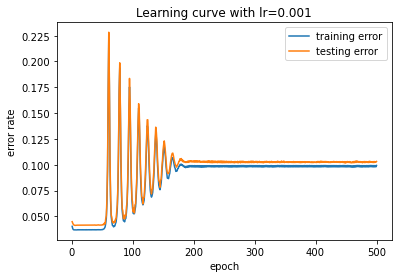

In [31]:
# generate data
X_data, y_data, mislabel = generate_data(20, 100000) 

# split data
X_train = X_data[0:90000]
y_train = y_data[0:90000]
X_test = X_data[90001:]
y_test = y_data[90001:]

# constrcut model and train (remember record time)
model1 = SVM1(20, learning_rate=0.001, max_iter=500, C=1)
model1.fit(X_train, y_train, val_data=(X_test, y_test)) 
# model1.fit()
# make prediction
# pred = model1.predict()

# predict and calculate acc
train_acc = model1.score(X_train, y_train, metric='acc')
test_acc = model1.score(X_test, y_test, metric='acc')
print("train acc = {0}".format(train_acc))
print("test acc = {0}".format(test_acc))

# plot learning curve and decision boundary
# 如果是高维度决策图是没有意义的，这里我只是尝试在 2 维的情况下绘制
print("错误率曲线如下：")
model1.plot_learning_curve()
# model1.plot_boundary(X_train, y_train, sv=True)
# model1.plot_boundary(X_test, y_test, sv=False)

# compared with answer

# compare each methods

## 方法 2：SMO（跑完大概需要 5 min）

In [32]:

# generate data
X_data, y_data, mislabel = generate_data(20, 10000) 
# print(X_data)
# print(y_data)

# split data
X_train = X_data[0:9000]
y_train = y_data[0:9000]
X_test = X_data[9001:]
y_test = y_data[9001:]

# constrcut model and train (remember record time)
model2 = SVM2(20, maxiter=1000, C=1)
model2.fit(X_train, y_train, val_data=(X_test, y_test))


已经1个epoch, train_acc=0.503789
已经2个epoch, train_acc=0.503789
已经3个epoch, train_acc=0.638368
已经4个epoch, train_acc=0.638368
已经5个epoch, train_acc=0.638368
已经6个epoch, train_acc=0.638368
已经7个epoch, train_acc=0.638368
已经8个epoch, train_acc=0.638368
已经9个epoch, train_acc=0.638368
已经10个epoch, train_acc=0.638368
已经11个epoch, train_acc=0.638368
已经12个epoch, train_acc=0.638368
已经13个epoch, train_acc=0.638368
已经14个epoch, train_acc=0.638368
已经15个epoch, train_acc=0.638368
已经16个epoch, train_acc=0.604263
已经17个epoch, train_acc=0.604263
已经18个epoch, train_acc=0.604263
已经19个epoch, train_acc=0.604263
已经20个epoch, train_acc=0.604263
已经21个epoch, train_acc=0.651263
已经22个epoch, train_acc=0.682895
已经23个epoch, train_acc=0.682895
已经24个epoch, train_acc=0.682895
已经25个epoch, train_acc=0.682895
已经26个epoch, train_acc=0.704000
已经27个epoch, train_acc=0.710895
已经28个epoch, train_acc=0.694632
已经29个epoch, train_acc=0.694632
已经30个epoch, train_acc=0.694632
已经31个epoch, train_acc=0.694632
已经32个epoch, train_acc=0.686158
已经33个epoch, train

train acc = 0.9013684210526316
test acc = 0.8858858858858859
错误率曲线如下：


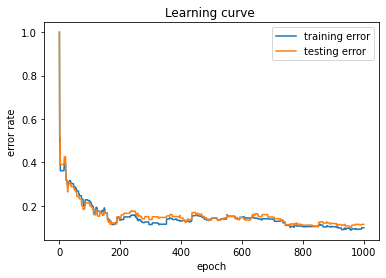

In [33]:
# make prediction
# pred = model1.predict()

# predict and calculate acc
train_acc = model2.score(X_train, y_train, metric='acc')
test_acc = model2.score(X_test, y_test, metric='acc')
print("train acc = {0}".format(train_acc))
print("test acc = {0}".format(test_acc))
print("错误率曲线如下：")
model2.plot_learning_curve()



## 调用 sklearn 库进行对比（跑完大概需要 30s）

In [34]:
from sklearn.svm import SVC, LinearSVC
from sklearn import metrics
model = SVC(kernel='linear')
model.fit(X_train, y_train)
prediction = model.predict(X_test)
print("标准库准确率：", metrics.accuracy_score(prediction, y_test))

/Users/jianglei/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


标准库准确率： 0.954954954954955
